<a href="https://colab.research.google.com/github/aaart42/trading_pub/blob/main/RiskPremiaResearch_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# -*- coding: utf-8 -*-
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ========================
# Parameters
# ========================
etf = ["GLD", "TLT", "VTI"]
lookback = 30        # backward window (days)
look_forward = 30    # forward window (days)
allow_overlap = False # True = keep all rows (overlapping windows)
                     # False = only take every 'lookback'-th row (non-overlapping)


In [18]:
# ========================
# Download data
# ========================
data = yf.download(etf, period="max", auto_adjust=False)

# Use adjusted close; keep Date as a column (not as index)
adj_close = data["Adj Close"].reset_index()  # 'Date' stays a column

# ========================
# Reshape to long format
# ========================
adj_long = pd.melt(
    adj_close,
    id_vars=["Date"],
    value_vars=etf,
    var_name="Ticker",
    value_name="Price"
)

# Ensure chronological order within each Ticker for correct shift/rolling behavior
adj_long = adj_long.sort_values(["Ticker", "Date"]).reset_index(drop=True)

[*********************100%***********************]  3 of 3 completed


In [19]:
# ========================
# Returns (log)
# ========================

# 1-day log return
adj_long["log_return_1d"] = np.log(
    adj_long["Price"] / adj_long.groupby("Ticker")["Price"].shift(1)
)

# k-day past log return: log(P_t / P_{t-k})
adj_long["log_return_past"] = np.log(
    adj_long["Price"] / adj_long.groupby("Ticker")["Price"].shift(lookback)
)

# k-day forward log return: log(P_{t+k} / P_t)
# Uses prices from the next k days (no overlap with the past window)
adj_long["log_return_fwd"] = np.log(
    adj_long.groupby("Ticker")["Price"].shift(-look_forward) / adj_long["Price"]
)


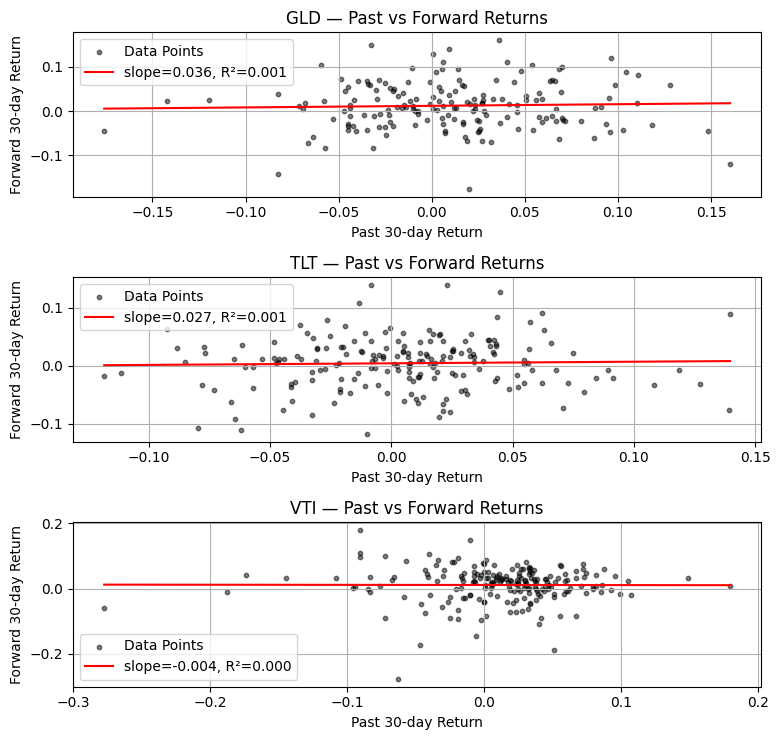

In [31]:
# ========================
# Prepare clean dataframe for returns plot
# ========================

# drop NaN rows that would break regression
adj_long_clean_ret = adj_long.dropna(
    subset=["log_return_past", "log_return_fwd"]
).copy()

# if overlap is disabled, take only every lookback-th observation per ticker
if allow_overlap == 0:
    adj_long_clean_ret = adj_long_clean_ret[
        adj_long_clean_ret.groupby("Ticker").cumcount() % lookback == 0
    ]

# ========================
# Scatter: past vs forward returns
# ========================
fig, axs = plt.subplots(len(etf), 1, figsize=(8, 2.5 * len(etf)), sharex=False, sharey=False)

for i, ticker in enumerate(etf):
    subset = adj_long_clean_ret[adj_long_clean_ret["Ticker"] == ticker]

    # scatter points
    axs[i].scatter(
        subset["log_return_past"], subset["log_return_fwd"],
        alpha=0.5, s=10, color="black", label="Data Points"
    )

    # linear regression line
    if len(subset) > 1:
        result = linregress(subset["log_return_past"], subset["log_return_fwd"])
        x_vals = np.array([subset["log_return_past"].min(), subset["log_return_past"].max()])
        y_vals = result.slope * x_vals + result.intercept
        axs[i].plot(x_vals, y_vals, color="red", label=f"slope={result.slope:.3f}, R²={result.rvalue**2:.3f}")

    # titles, labels, formatting
    axs[i].set_title(f"{ticker} — Past vs Forward Returns")
    axs[i].set_xlabel(f"Past {lookback}-day Return")
    axs[i].set_ylabel(f"Forward {look_forward}-day Return")
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [20]:
# ========================
# Volatility (annualized) — STRICT (exact)
# ========================

# Past strict: rolling std of last 'lookback' daily log returns (annualized)
adj_long["vol_past_strict"] = (
    adj_long.groupby("Ticker")["log_return_1d"]
            .rolling(window=lookback, min_periods=lookback)
            .std()
            .reset_index(level=0, drop=True)
            * np.sqrt(252)
)

# Forward strict: rolling std of next 'look_forward' daily log returns (annualized)
# Align future returns (t+1..t+k) to row t, then take rolling std over that future window.
adj_long["vol_fwd_strict"] = (
    adj_long.groupby("Ticker")["log_return_1d"]
            .shift(-look_forward + 1)
            .rolling(window=look_forward, min_periods=look_forward)
            .std()
            .reset_index(level=0, drop=True)
            * np.sqrt(252)
)

# ========================
# Volatility (annualized) — APPROX (shift/proxy, R-style)
# ========================

# Forward approx (R-style): lead the past strict vol by look_forward
adj_long["vol_fwd_approx"] = adj_long.groupby("Ticker")["vol_past_strict"].shift(-look_forward)

# Past approx (mirror proxy): lag the past strict vol by lookback
adj_long["vol_past_approx"] = adj_long.groupby("Ticker")["vol_past_strict"].shift(lookback)


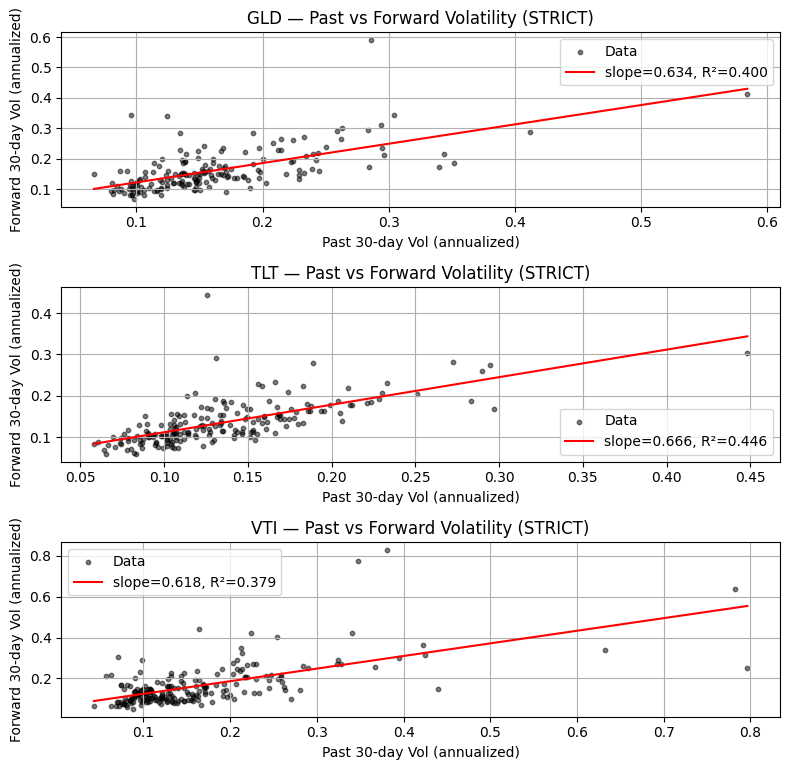

In [30]:
# ========================
# Clean rows for plotting (strict variants)
# ========================
adj_long_clean_strict = adj_long.dropna(
    subset=["vol_past_strict", "vol_fwd_strict"]
).copy()

# If overlap is disabled, keep every lookback-th observation per ticker
if allow_overlap == 0:
    adj_long_clean_strict = adj_long_clean_strict[adj_long_clean_strict.groupby("Ticker").cumcount() % lookback == 0]

# ========================
# Plot: past vs forward volatility (STRICT)
# ========================
fig, axs = plt.subplots(len(etf), 1, figsize=(8, 2.6 * len(etf)), sharex=False, sharey=False)
for i, ticker in enumerate(etf):
    sub = adj_long_clean_strict[adj_long_clean_strict["Ticker"] == ticker]
    axs[i].scatter(sub["vol_past_strict"], sub["vol_fwd_strict"], s=10, alpha=0.5, color="black", label="Data")
    if len(sub) > 1:
        res = linregress(sub["vol_past_strict"], sub["vol_fwd_strict"])
        x = np.array([sub["vol_past_strict"].min(), sub["vol_past_strict"].max()])
        y = res.slope * x + res.intercept
        axs[i].plot(x, y, color="red", label=f"slope={res.slope:.3f}, R²={res.rvalue**2:.3f}")
    axs[i].set_title(f"{ticker} — Past vs Forward Volatility (STRICT)")
    axs[i].set_xlabel(f"Past {lookback}-day Vol (annualized)")
    axs[i].set_ylabel(f"Forward {look_forward}-day Vol (annualized)")
    axs[i].grid(True); axs[i].legend(loc="best")
plt.tight_layout(); plt.show()

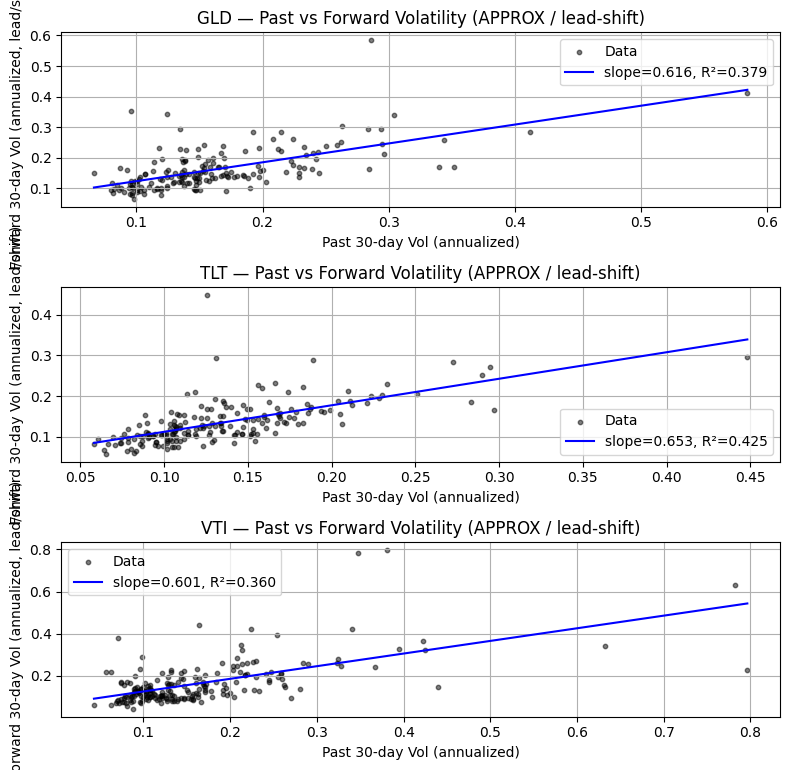

In [29]:

# ========================
# Clean rows for plotting (APPROX)
# ========================
adj_long_clean_approx = adj_long.dropna(
    subset=["vol_past_strict", "vol_fwd_approx"]
).copy()

# If overlap is disabled, keep every lookback-th observation per ticker
if allow_overlap == 0:
    adj_long_clean_approx = adj_long_clean_approx[adj_long_clean_approx.groupby("Ticker").cumcount() % lookback == 0]

# ========================
# Plot: past vs forward volatility (APPROX — R-style lead/shift)
# ========================
fig, axs = plt.subplots(len(etf), 1, figsize=(8, 2.6 * len(etf)), sharex=False, sharey=False)
for i, ticker in enumerate(etf):
    sub = adj_long_clean_approx[adj_long_clean_approx["Ticker"] == ticker]
    axs[i].scatter(sub["vol_past_strict"], sub["vol_fwd_approx"], s=10, alpha=0.5, color="black", label="Data")
    if len(sub) > 1:
        res = linregress(sub["vol_past_strict"], sub["vol_fwd_approx"])
        x = np.array([sub["vol_past_strict"].min(), sub["vol_past_strict"].max()])
        y = res.slope * x + res.intercept
        axs[i].plot(x, y, color="blue", label=f"slope={res.slope:.3f}, R²={res.rvalue**2:.3f}")
    axs[i].set_title(f"{ticker} — Past vs Forward Volatility (APPROX / lead-shift)")
    axs[i].set_xlabel(f"Past {lookback}-day Vol (annualized)")
    axs[i].set_ylabel(f"Forward {look_forward}-day Vol (annualized, lead/shift)")
    axs[i].grid(True); axs[i].legend(loc="best")
plt.tight_layout(); plt.show()